<a href="https://colab.research.google.com/github/Nipuna754/Blockchain/blob/main/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First 5 rows of data:
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


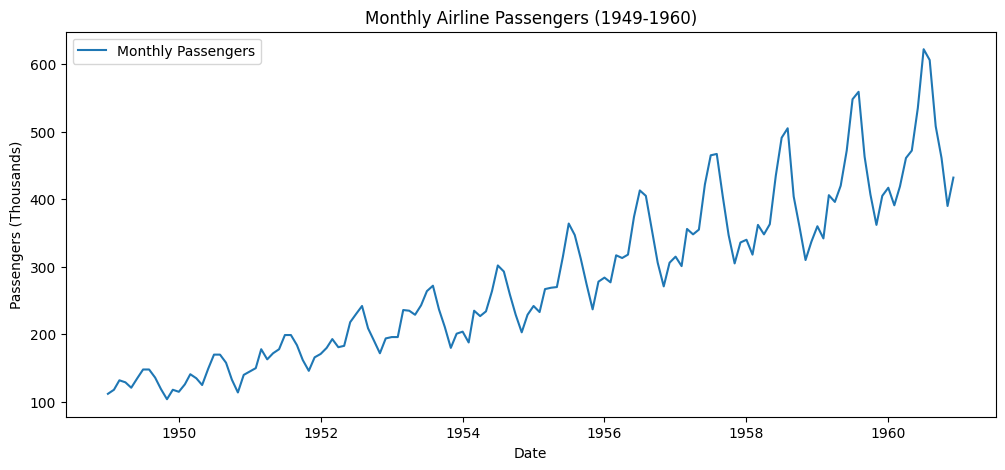


Missing values in dataset: 0
ADF Test:
ADF Statistic: 0.8154
p-value: 0.9919
Critical Value 1%: -3.4817
Critical Value 5%: -2.8840
Critical Value 10%: -2.5788
=> The series is non-stationary.


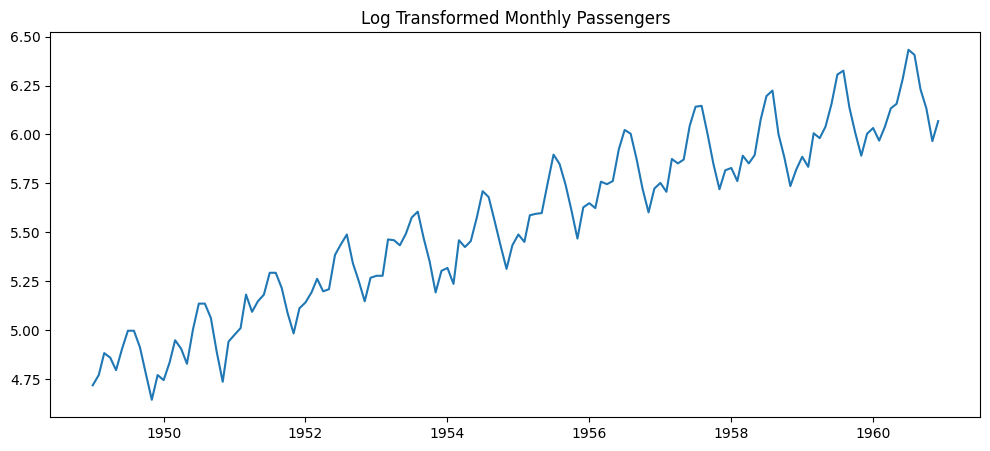

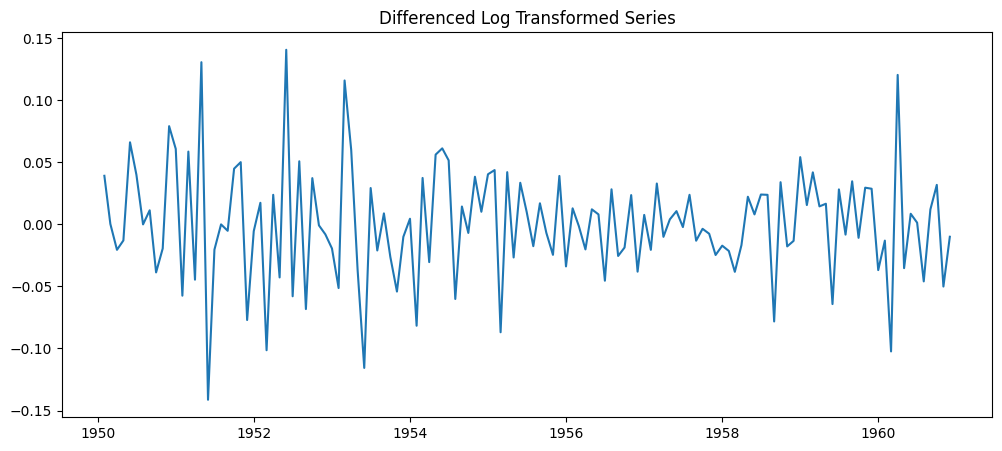

ADF Test:
ADF Statistic: -4.4433
p-value: 0.0002
Critical Value 1%: -3.4870
Critical Value 5%: -2.8864
Critical Value 10%: -2.5800
=> The series is stationary.


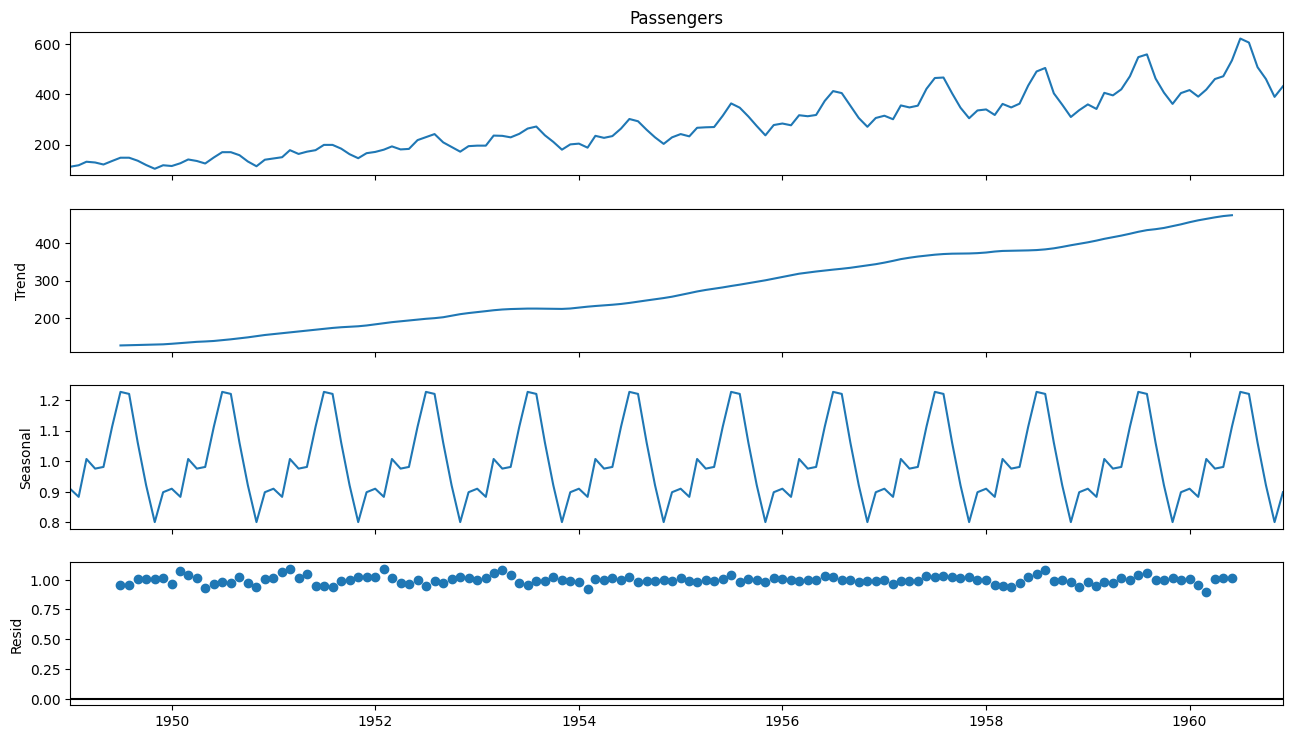

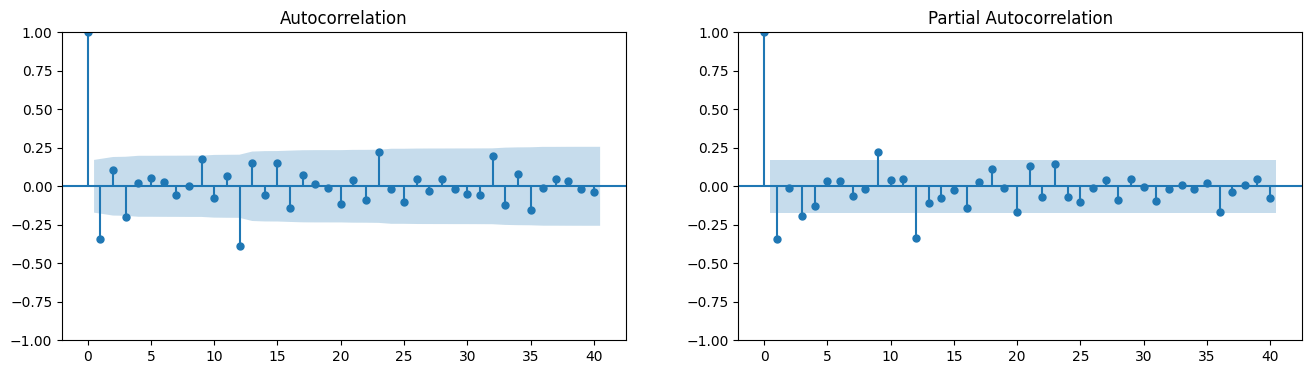

                                      SARIMAX Results                                       
Dep. Variable:                       Log_Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 217.877
Date:                              Sun, 13 Jul 2025   AIC                           -421.755
Time:                                      14:35:52   BIC                           -402.480
Sample:                                  01-01-1949   HQIC                          -413.930
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6604      0.249     -2.647      0.008      -1.149      -0.171
ar.L2          0.09

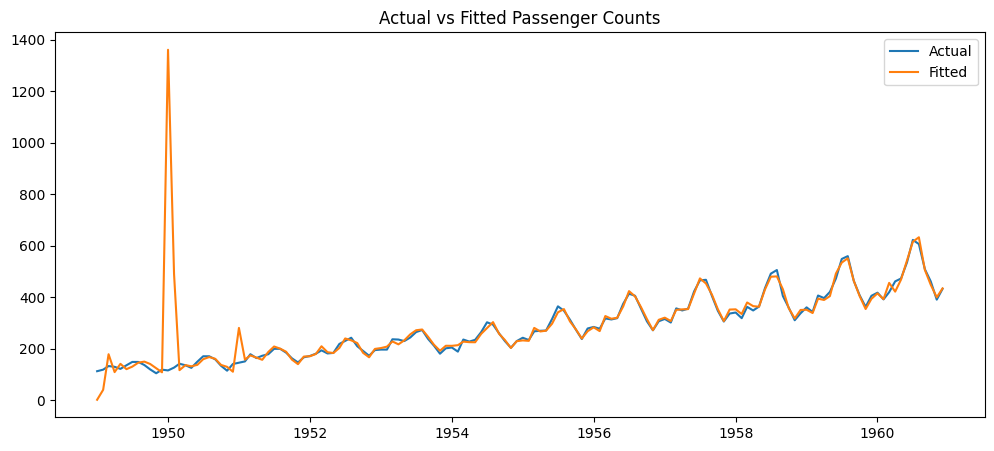

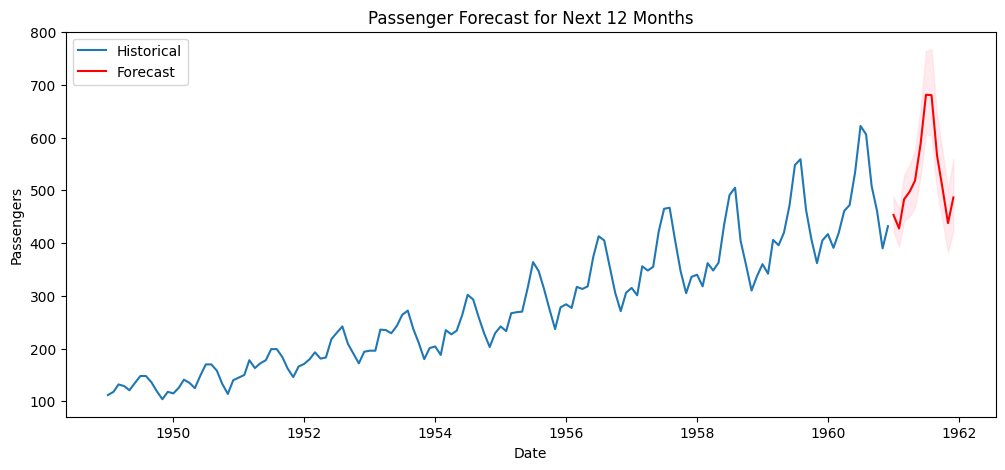

Forecasted passenger numbers for next 12 months:
1961-01: 453 passengers
1961-02: 427 passengers
1961-03: 483 passengers
1961-04: 497 passengers
1961-05: 518 passengers
1961-06: 587 passengers
1961-07: 681 passengers
1961-08: 680 passengers
1961-09: 565 passengers
1961-10: 504 passengers
1961-11: 437 passengers
1961-12: 486 passengers


In [ ]:
# Step 0: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Step 1: Data Collection & Exploration
# Load AirPassengers dataset (built-in in statsmodels or from URL)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

print("First 5 rows of data:")
print(df.head())

# Plot the time series
plt.figure(figsize=(12,5))
plt.plot(df, label='Monthly Passengers')
plt.title('Monthly Airline Passengers (1949-1960)')
plt.ylabel('Passengers (Thousands)')
plt.xlabel('Date')
plt.legend()
plt.show()

# Step 2: Data Preprocessing

# 2a: Check for missing values
print("\nMissing values in dataset:", df.isnull().sum().values[0])

# 2b: Stationarity Check using Augmented Dickey-Fuller test
def adf_test(series):
    print('ADF Test:')
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value:.4f}')
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")

adf_test(df['Passengers'])

# Since p-value > 0.05, the series is non-stationary (expected due to trend and seasonality)

# 2c: Transformation - Log transform to stabilize variance
df['Log_Passengers'] = np.log(df['Passengers'])

plt.figure(figsize=(12,5))
plt.plot(df['Log_Passengers'], label='Log Transformed Passengers')
plt.title('Log Transformed Monthly Passengers')
plt.show()

# 2d: Differencing to remove trend and seasonality
df['Log_Diff'] = df['Log_Passengers'].diff().diff(12)  # First difference and seasonal difference (lag 12)

plt.figure(figsize=(12,5))
plt.plot(df['Log_Diff'], label='Differenced Log Passengers')
plt.title('Differenced Log Transformed Series')
plt.show()

# Drop NA values created by differencing
df_diff = df['Log_Diff'].dropna()

# Check stationarity again after differencing
adf_test(df_diff)

# Step 3: Decomposition
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative', period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

# Step 4: Model Selection & Fitting

# Plot ACF and PACF to help select ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(df_diff, lags=40, ax=axes[0])
plot_pacf(df_diff, lags=40, ax=axes[1])
plt.show()

# Based on plots and domain knowledge, we try ARIMA(2,1,2)(1,1,1,12)
# p,d,q = 2,1,2 (non-seasonal), P,D,Q,s = 1,1,1,12 (seasonal)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['Log_Passengers'],
                order=(2,1,2),
                seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit()
print(model_fit.summary())

# Step 5: Model Evaluation

# In-sample prediction
df['Predicted_Log'] = model_fit.predict(start=0, end=len(df)-1, dynamic=False)
df['Predicted'] = np.exp(df['Predicted_Log'])

# Calculate error metrics on training data
rmse = np.sqrt(mean_squared_error(df['Passengers'], df['Predicted']))
mae = mean_absolute_error(df['Passengers'], df['Predicted'])
print(f"\nTraining RMSE: {rmse:.2f}")
print(f"Training MAE: {mae:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(df['Passengers'], label='Actual')
plt.plot(df['Predicted'], label='Fitted')
plt.title('Actual vs Fitted Passenger Counts')
plt.legend()
plt.show()

# Step 6: Forecasting & Prediction

# Forecast next 12 months
forecast_steps = 12
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Convert forecast back from log scale
forecast_values = np.exp(forecast.predicted_mean)

# Create forecast index
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

# Plot forecast
plt.figure(figsize=(12,5))
plt.plot(df['Passengers'], label='Historical')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index,
                 np.exp(forecast_ci.iloc[:, 0]),
                 np.exp(forecast_ci.iloc[:, 1]),
                 color='pink', alpha=0.3)
plt.title('Passenger Forecast for Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Step 7: Interpretation & Reporting

print("Forecasted passenger numbers for next 12 months:")
for date, value in zip(forecast_index, forecast_values):
    print(f"{date.strftime('%Y-%m')}: {int(value)} passengers")